In [1]:
!pip install --upgrade Pillow

import torch
import torchvision
from datasets import load_dataset
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
# import timm
# import detectors

  Using cached pillow-10.3.0-cp39-cp39-macosx_10_10_x86_64.whl.metadata (9.2 kB)
Using cached pillow-10.3.0-cp39-cp39-macosx_10_10_x86_64.whl (3.5 MB)
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0


/Users/tatami/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/tatami/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Cifar 10 data import
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

# Download and load the training data
trainset_cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset_cifar10, batch_size=4, shuffle=True)

# Download and load the test data
testset_cifar10 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset_cifar10, batch_size=4, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Cifar100 data import

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5070, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))  # Normalize the images
])

augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5070, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

# Download and load the training data
trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=None)
testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
from copy import deepcopy
from torch.utils.data import Subset, Dataset
from PIL import Image

# Transform 
def sparse2coarse(targets):
    """Convert Pytorch CIFAR100 sparse targets to coarse targets.

    Usage:
        trainset = torchvision.datasets.CIFAR100(path)
        trainset.targets = sparse2coarse(trainset.targets)
    """
    coarse_labels = np.array([ 4,  1, 14,  8,  0,  6,  7,  7, 18,  3,  
                               3, 14,  9, 18,  7, 11,  3,  9,  7, 11,
                               6, 11,  5, 10,  7,  6, 13, 15,  3, 15,  
                               0, 11,  1, 10, 12, 14, 16,  9, 11,  5, 
                               5, 19,  8,  8, 15, 13, 14, 17, 18, 10, 
                               16, 4, 17,  4,  2,  0, 17,  4, 18, 17, 
                               10, 3,  2, 12, 12, 16, 12,  1,  9, 19,  
                               2, 10,  0,  1, 16, 12,  9, 13, 15, 13, 
                              16, 19,  2,  4,  6, 19,  5,  5,  8, 19, 
                              18,  1,  2, 15,  6,  0, 17,  8, 14, 13])
    return coarse_labels[targets]

# Construct Coarse Dataset With the Function
superclasses = ['aquatic_mammals','fish','flowers','food_containers','fruit_and_vegetables','household_electrical_devices',
                'household_furniture','insects','large_carnivores','large_man-made_outdoor_things','large_natural_outdoor_scenes',
                'large_omnivores_and_herbivores','medium-sized_mammals','non-insect_invertebrates','people','reptiles','small_mammals',
                'trees','vehicles 1','vehicles 2']
trainset_coarse = deepcopy(trainset)
trainset_coarse.targets = sparse2coarse(trainset_coarse.targets)
trainset_coarse.classes = superclasses
trainset_coarse.class_to_idx = dict(zip(trainset_coarse.classes,range(len(trainset_coarse.classes))))
testset_coarse = deepcopy(testset)
testset_coarse.targets = sparse2coarse(testset_coarse.targets)
testset_coarse.classes = superclasses
testset_coarse.class_to_idx = dict(zip(testset_coarse.classes, range(len(testset_coarse.classes))))

# Make Splits
trainsplit_coarse, validsplit_coarse = random_split(trainset_coarse,[int(len(trainset_coarse) * 0.9), len(trainset_coarse) - int(len(trainset_coarse) * 0.9)])
trainsplit_fine, validsplit_fine = random_split(trainset,[int(len(trainset) * 0.9), len(trainset) - int(len(trainset) * 0.9)])

# Apply Respective Transforms to the splits
class TransformedSubset(Dataset):
# class TransformedSubset(Subset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
#         super(TransformedSubset, self).__init__(dataset, indices)
#         self.transform = transform

    def __getitem__(self, idx):
#         img, label = self.dataset[self.indices[idx]]
#         img = self.transform(img)
#         return img, label
        img, label = self.dataset[self.indices[idx]]
        if isinstance(img, Image.Image):
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.indices)
    
trainsplit_coarse = TransformedSubset(trainset_coarse, trainsplit_coarse.indices, augmentation_transform)
validsplit_coarse = TransformedSubset(trainset_coarse, validsplit_coarse.indices, transform)
trainsplit_fine = TransformedSubset(trainset, trainsplit_fine.indices, augmentation_transform)
validsplit_fine = TransformedSubset(trainset, validsplit_fine.indices, transform)


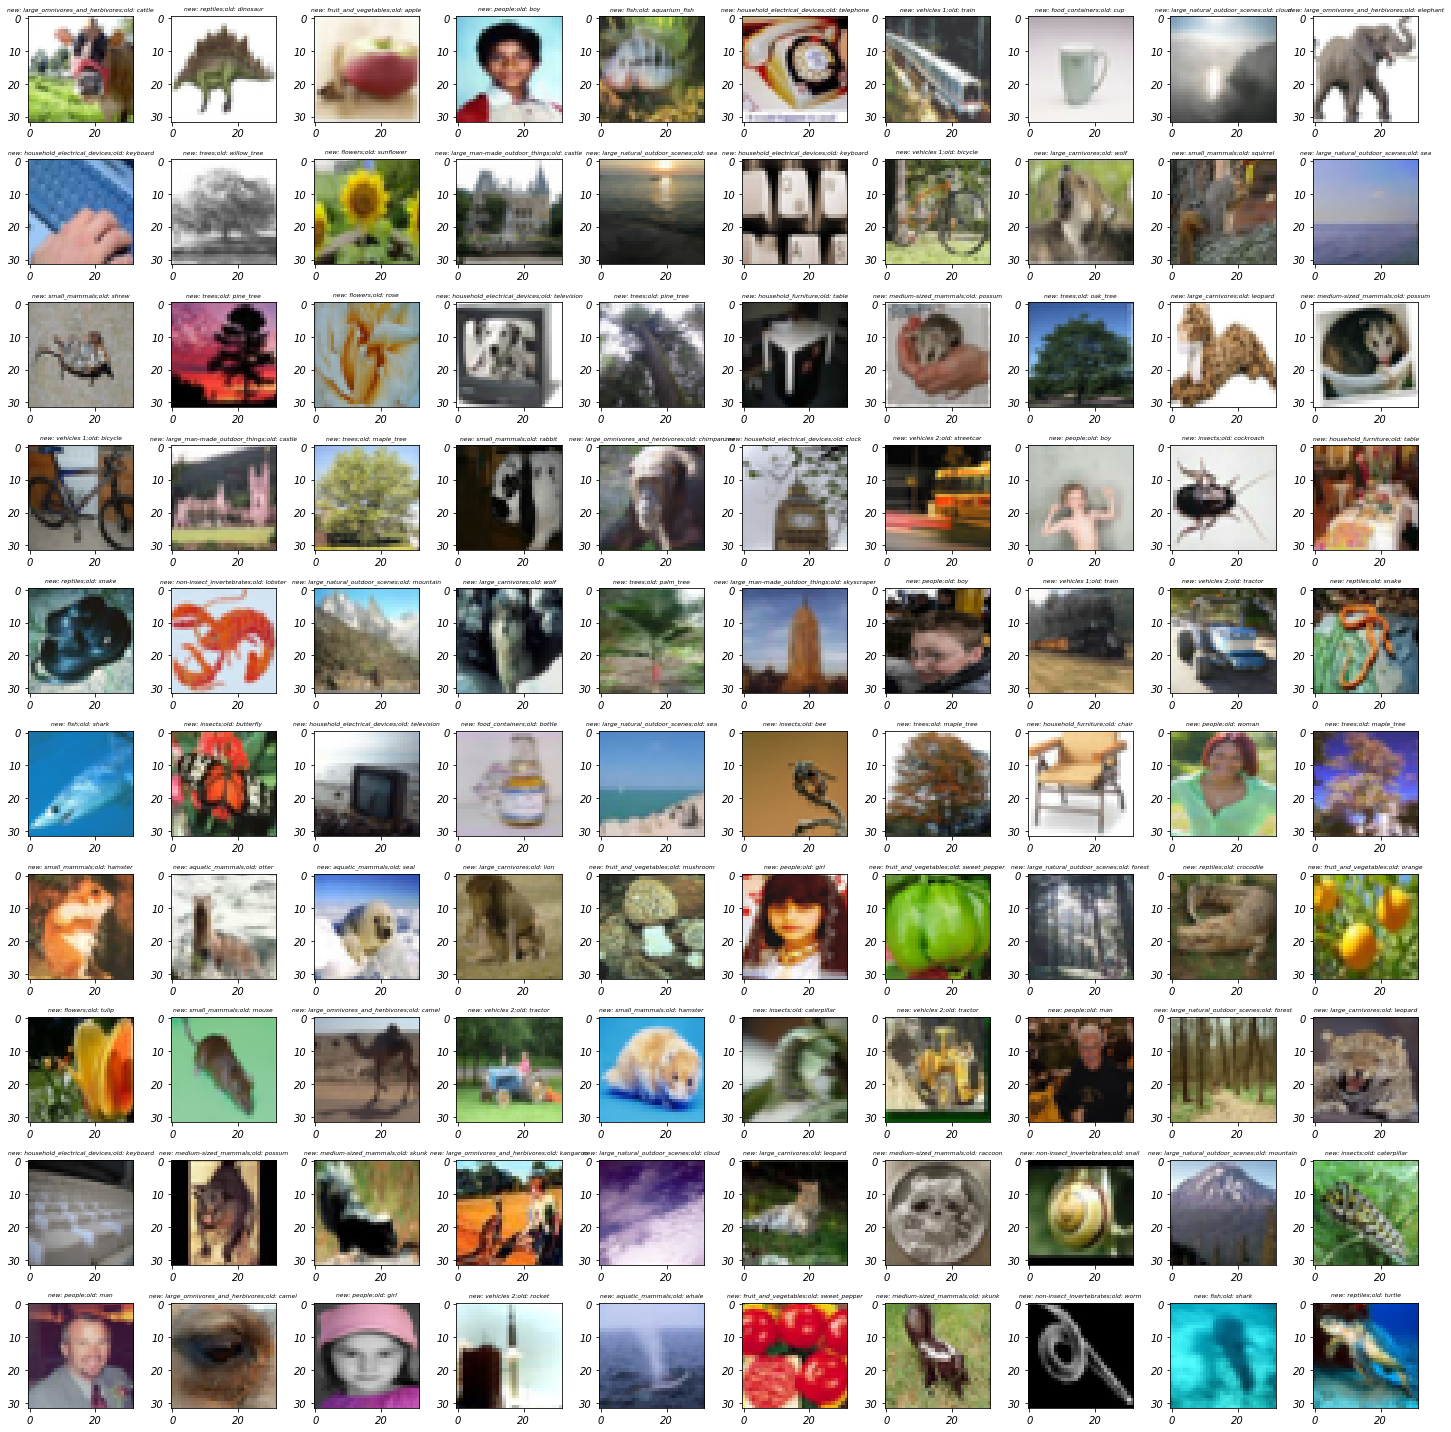

In [5]:
# Visualize Coarse Dataset
import matplotlib.pyplot as plt
fig, ax = plt.subplots(10,10, figsize = (20,20))
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(np.array(trainset[i*10 + j][0]))
        ax[i,j].set_title(f'new: {trainset_coarse.classes[trainset_coarse[i*10 + j][1]]};old: {trainset.classes[trainset[i*10 + j][1]]}',fontsize = 6)
plt.tight_layout()
plt.show()

In [8]:
# Prepare the Dataloaders

coarsetrain_loader = DataLoader(trainsplit_coarse, batch_size = 256, shuffle= True)
coarsevalid_loader = DataLoader(validsplit_coarse, batch_size = 256, shuffle= True)
coarsetest_loader = DataLoader(testset_coarse, batch_size = 256, shuffle= True)
finetrain_loader = DataLoader(trainsplit_fine, batch_size = 256, shuffle= True)
finevalid_loader = DataLoader(validsplit_fine, batch_size = 256, shuffle= True)
finetest_loader = DataLoader(testset, batch_size = 256, shuffle= True)

# Define the Predict Function
def predict(output):
    return torch.argmax(output, dim = 1)

# Define the Train Function
def train(model, train_dataloader, valid_dataloader, epochs, save_path, save_name, checkpoint_path=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Training on device: {device}')
    model.to(device)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2) #learning rate decay
    # optimizer = torch.optim.Adam(params= model.parameters(), lr = 0.1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epochs, eta_min = 0)
    criterion = torch.nn.CrossEntropyLoss()
    best_loss = float('inf')
    
    start_epoch = 0
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        best_loss = checkpoint.get('best_loss', best_loss)
        print(f"Resumed training from epoch {start_epoch} with best validation loss {best_loss}")

    trloss_arr = []
    tracc_arr = []
    vldloss_arr = []
    vldacc_arr = []
    
    for epoch in range(start_epoch,epochs):
        model.train()
        train_loss = 0
        corrects = 0
        total = 0
        
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device).long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            corrects += torch.sum(torch.eq(predict(outputs), labels))
            total += inputs.size(0)
            
        trloss_arr.append(train_loss / len(train_dataloader))
        tracc_arr.append(corrects / total)

        model.eval()
        valid_loss = 0
        corrects = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in valid_dataloader:
                inputs, labels = inputs.to(device), labels.to(device).long()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                corrects += torch.sum(torch.eq(predict(outputs),labels))
                total += inputs.size(0)
            vldloss_arr.append(valid_loss / len(valid_dataloader))
            vldacc_arr.append(corrects / total)
        print('Epoch: {ep}, TrainingLoss: {tl}, TrainingAccuracy: {ta}, ValidationLoss: {vl}, ValidationAccuracy: {va}'.format(ep = epoch, tl = trloss_arr[-1], ta = tracc_arr[-1], vl = vldloss_arr[-1], va = vldacc_arr[-1]))
        
        if vldloss_arr[-1] < best_loss:
            best_loss = vldloss_arr[-1]
            torch.save({'epoch': epoch + 1,
             'model_state_dict': model.state_dict(), 
             'optimizer_state_dict':optimizer.state_dict(), 
             'scheduler_state_dict':scheduler.state_dict(),
             'best_loss': best_loss},
                       f'{save_path}/{save_name}.pth')
            print('Best Loss: saving model...')

    return trloss_arr, tracc_arr, vldloss_arr, vldacc_arr

In [9]:
# Modify the Model Architecture to train on coarse labels
torch.cuda.empty_cache()
# coarse_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet36", pretrained=False)
coarse_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
coarse_model.fc = torch.nn.Linear(coarse_model.fc.in_features, 20)
trloss_arr, tracc_arr, vldloss_arr, vldacc_arr = train(coarse_model, coarsetrain_loader, coarsevalid_loader, 1, '.', 'fullRes_coarse')

Using cache found in /Users/tatami/.cache/torch/hub/pytorch_vision_v0.10.0


Training on device: cpu
Epoch: 0, TrainingLoss: 2.776530376889489, TrainingAccuracy: 0.1936444491147995, ValidationLoss: 2.378339874744415, ValidationAccuracy: 0.25839999318122864
Best Loss: saving model...


In [10]:
fine_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=True)
fine_model.fc = torch.nn.Linear(fine_model.fc.in_features, 100)
trloss_arr, tracc_arr, vldloss_arr, vldacc_arr = train(fine_model, finetrain_loader, finevalid_loader, 1, '.', 'fine_checkpoint')

Using cache found in /Users/tatami/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Training on device: cpu
Epoch: 0, TrainingLoss: 2.0672014240514147, TrainingAccuracy: 0.4493333399295807, ValidationLoss: 2.785844957828522, ValidationAccuracy: 0.3723999857902527
Best Loss: saving model...


In [50]:
def test(model, test_dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Training on device: {device}')
    model.to(device)
    
    model.eval()
    
    criterion = torch.nn.CrossEntropyLoss()
    test_loss = 0
    corrects = 0
    total = 0
    
    with torch.no_grad():
#         print(test_dataloader)
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device).long()
#             print("Labels:", labels)  # Debug statement
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            corrects += (predicted == labels).sum().item()
            total += labels.size(0)
    
    avg_test_loss = test_loss / len(test_dataloader)
    test_accuracy = corrects / total
    
    print(f'Test Loss: {avg_test_loss}, Test Accuracy: {test_accuracy}')
    return avg_test_loss, test_accuracy

In [12]:
# Use the test function
coarsetest_loss, coarsetest_accuracy = test(coarse_model, coarsetest_loader)
finetest_loss, finetest_accuracy = test(fine_model, finetest_loader)

Training on device: cpu
Test Loss: 2.3909064292907716, Test Accuracy: 0.2579
Training on device: cpu
Test Loss: 2.9106400847434997, Test Accuracy: 0.3627


In [ ]:
# # ImageNet 64

# dataset = load_dataset("zh-plus/tiny-imagenet")
# imagenet_train = dataset['train']
# imagenet_valid = dataset['valid']

# tiny_imagenet_train_loader = torch.utils.data.DataLoader(imagenet_train, batch_size=256, shuffle=True)
# tiny_imagenet_valid_loader = torch.utils.data.DataLoader(imagenet_valid, batch_size=256, shuffle=True)

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

In [46]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os, glob
from torchvision.io import read_image, ImageReadMode

class TrainTinyImageNetDataset(Dataset):
    def __init__(self, id_dict, transform=None):
        self.filenames = glob.glob("./tiny-imagenet-200/train/*/*/*.JPEG")
        self.transform = transform
        self.id_dict = id_dict

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        image = read_image(img_path)
        if image.shape[0] == 1:
            image = read_image(img_path, ImageReadMode.RGB)
        label = self.id_dict[img_path.split('/')[3]]
        if self.transform:
            image = self.transform(image.type(torch.FloatTensor))
        return image, label

    
batch_size = 256

# Load IDs from wnids.txt file
id_dict = {}
with open('./tiny-imagenet-200/wnids.txt', 'r') as f:
    for i, line in enumerate(f):
        id_dict[line.strip()] = i

transform = transforms.Normalize((122.4786, 114.2755, 101.3963), (70.4924, 68.5679, 71.8127))

trainsplit_imagenet = TrainTinyImageNetDataset(id_dict, transform)
tiny_imagenet_train_loader = DataLoader(trainsplit_imagenet, batch_size = 256, shuffle= True)

In [47]:
class TestTinyImageNetDataset(Dataset):
    def __init__(self, id_dict, transform=None):
        self.filenames = glob.glob("./tiny-imagenet-200/val/images/*.JPEG")
        self.transform = transform
        self.id_dict = id_dict
        self.cls_dic = {}
        for i, line in enumerate(open('./tiny-imagenet-200/val/val_annotations.txt', 'r')):
            a = line.split('\t')
            img, cls_id = a[0], a[1]
            self.cls_dic[img] = self.id_dict[cls_id]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        image = read_image(img_path)
        if image.shape[0] == 1:
            image = read_image(img_path, ImageReadMode.RGB)
        label = self.cls_dic[img_path.split('/')[-1]]
        if self.transform:
            image = self.transform(image.type(torch.FloatTensor))
        return image, label
    
batch_size = 256

# Load IDs from wnids.txt file
id_dict = {}
with open('./tiny-imagenet-200/wnids.txt', 'r') as f:
    for i, line in enumerate(f):
        id_dict[line.strip()] = i

transform = transforms.Normalize((122.4786, 114.2755, 101.3963), (70.4924, 68.5679, 71.8127))

validsplit_imagenet = TrainTinyImageNetDataset(id_dict, transform)
tiny_imagenet_valid_loader = DataLoader(validsplit_imagenet, batch_size = 256, shuffle= True)

In [48]:
# FineTune Model - resnet18
coarse_model_imagenet = deepcopy(coarse_model)

# Modify the model for Tiny-ImageNet (200 classes)
coarse_model_imagenet.fc = torch.nn.Linear(coarse_model_imagenet.fc.in_features, 200)

trloss_arr_coarse, tracc_arr_coarse, vldloss_arr_coarse, vldacc_arr_coarse = train(coarse_model_imagenet, tiny_imagenet_train_loader, tiny_imagenet_valid_loader, 1, '.', 'imagenet_fine_model_finetuned')
# test(coarse_model_imagenet, tiny_imagenet_valid_loader)

# # Filter unseen classes
# unseen_classes = [class_label for class_label in tiny_imagenet_classes if class_label not in cifar100_classes]

Training on device: cpu
Epoch: 0, TrainingLoss: 4.249526758633001, TrainingAccuracy: 0.10730999708175659, ValidationLoss: 3.7741233985442335, ValidationAccuracy: 0.1672700047492981
Best Loss: saving model...


NameError: name 'evaluate_model' is not defined

In [57]:
# Get the parameters of coarse_model_imagenet
# Print a summary of the model's parameters
def summarize_parameters(model):
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            param_size = tuple(param.size())
            total_params += param.numel()
            print(f"Layer: {name} | Size: {param_size}")
    print(f"Total trainable parameters: {total_params}")

# Call the function with previous coarse_model
summarize_parameters(coarse_model)

Layer: conv1.weight | Size: (64, 3, 7, 7)
Layer: bn1.weight | Size: (64,)
Layer: bn1.bias | Size: (64,)
Layer: layer1.0.conv1.weight | Size: (64, 64, 3, 3)
Layer: layer1.0.bn1.weight | Size: (64,)
Layer: layer1.0.bn1.bias | Size: (64,)
Layer: layer1.0.conv2.weight | Size: (64, 64, 3, 3)
Layer: layer1.0.bn2.weight | Size: (64,)
Layer: layer1.0.bn2.bias | Size: (64,)
Layer: layer1.1.conv1.weight | Size: (64, 64, 3, 3)
Layer: layer1.1.bn1.weight | Size: (64,)
Layer: layer1.1.bn1.bias | Size: (64,)
Layer: layer1.1.conv2.weight | Size: (64, 64, 3, 3)
Layer: layer1.1.bn2.weight | Size: (64,)
Layer: layer1.1.bn2.bias | Size: (64,)
Layer: layer2.0.conv1.weight | Size: (128, 64, 3, 3)
Layer: layer2.0.bn1.weight | Size: (128,)
Layer: layer2.0.bn1.bias | Size: (128,)
Layer: layer2.0.conv2.weight | Size: (128, 128, 3, 3)
Layer: layer2.0.bn2.weight | Size: (128,)
Layer: layer2.0.bn2.bias | Size: (128,)
Layer: layer2.0.downsample.0.weight | Size: (128, 64, 1, 1)
Layer: layer2.0.downsample.1.weight |

In [56]:
# Call the function with new coarse_model_imagenet
summarize_parameters(coarse_model_imagenet)

Layer: conv1.weight | Size: (64, 3, 7, 7)
Layer: bn1.weight | Size: (64,)
Layer: bn1.bias | Size: (64,)
Layer: layer1.0.conv1.weight | Size: (64, 64, 3, 3)
Layer: layer1.0.bn1.weight | Size: (64,)
Layer: layer1.0.bn1.bias | Size: (64,)
Layer: layer1.0.conv2.weight | Size: (64, 64, 3, 3)
Layer: layer1.0.bn2.weight | Size: (64,)
Layer: layer1.0.bn2.bias | Size: (64,)
Layer: layer1.1.conv1.weight | Size: (64, 64, 3, 3)
Layer: layer1.1.bn1.weight | Size: (64,)
Layer: layer1.1.bn1.bias | Size: (64,)
Layer: layer1.1.conv2.weight | Size: (64, 64, 3, 3)
Layer: layer1.1.bn2.weight | Size: (64,)
Layer: layer1.1.bn2.bias | Size: (64,)
Layer: layer2.0.conv1.weight | Size: (128, 64, 3, 3)
Layer: layer2.0.bn1.weight | Size: (128,)
Layer: layer2.0.bn1.bias | Size: (128,)
Layer: layer2.0.conv2.weight | Size: (128, 128, 3, 3)
Layer: layer2.0.bn2.weight | Size: (128,)
Layer: layer2.0.bn2.bias | Size: (128,)
Layer: layer2.0.downsample.0.weight | Size: (128, 64, 1, 1)
Layer: layer2.0.downsample.1.weight |

In [ ]:
# FineTune Model - resnet20
fine_model_imagenet = deepcopy(fine_model)

# Modify the model for Tiny-ImageNet (200 classes)
fine_model_imagenet.fc = torch.nn.Linear(fine_model_imagenet.fc.in_features, 200)

trloss_arr_fine, tracc_arr_fine, vldloss_arr_fine, vldacc_arr_fine = train(fine_model_imagenet, tiny_imagenet_train_loader, tiny_imagenet_valid_loader, 1, '.', 'imagenet_fine_model_finetuned')
# test(fine_model_imagenet, tiny_imagenet_valid_loader)

# # Filter unseen classes
# unseen_classes = [class_label for class_label in tiny_imagenet_classes if class_label not in cifar100_classes]
# print(len(unseen_classes))

In [ ]:
# Get model parameters

# Apply Model Merging


